# Pairing HamiltonianのVQE計算 (Pennylane)

In [1]:
import numpy as np
import itertools
from itertools import combinations
import matplotlib.pyplot as plt

## Hamiltonianの準備

pairing Hamiltonianは以下のように書ける:

$$
H = \sum_{p} \epsilon_p N_p - g \sum_{pq} P^{\dagger}_p P_q
$$

$p,q$は二重縮退した軌道のラベルであり、$N_p$は数演算子である。
$P^{\dagger}_p$, $P_p$はそれぞれ軌道$p$にペアの粒子を生成/消滅する演算子である。

以下ではまずペアリングハミルトニアンの行列要素を計算するためのクラスを定義しておく。

In [2]:
class PairingHamiltonian:
    def __init__(self, Norb, Nocc, gval, delta_eps=1.0):
        self.Norb = Norb
        self.Nocc = Nocc
        self.delta_eps = delta_eps
        self.gval = gval
        self.basis = self.make_basis()
        self.epsilon = self.eval_epsilon()
        self.Hmat = self.eval_Hmat()

    def make_basis(self):
        self.basis = []
        for occ in combinations(range(self.Norb), self.Nocc):
            self.basis.append(occ)

        return self.basis
    
    def eval_epsilon(self):
        self.epsilon = [ 2 * i * self.delta_eps for i in range(self.Norb) ]
        return self.epsilon
    
    def eval_Hmat(self):
        dim = len(self.basis)
        self.Hmat = np.zeros((dim, dim))
        for bra_idx, bra in enumerate(self.basis):
            for ket_idx, ket in enumerate(self.basis):
                # Hamming distance
                diff = [ i for i in bra if i not in ket ]
                same = [ i for i in bra if i in ket ]
                # for SPE term
                if bra_idx == ket_idx:
                    self.Hmat[bra_idx, ket_idx] += np.sum( [self.epsilon[i] for i in same])
                    self.Hmat[bra_idx, ket_idx] += - self.gval * len(same) 
                # for pairing term
                if len(diff) == 1:
                    self.Hmat[bra_idx, ket_idx] = - self.gval

        return self.Hmat

def tuple_to_bitstring(tup, Norb, rev=True):
    bitint = 0
    for i in tup:
        bitint += 2**i
    if rev:
        bitstring = "|"+format(bitint, f'0{Norb}b')[::-1]+">"
    else:
        bitstring = "|"+format(bitint, f'0{Norb}b')+">"        
    return bitstring

Norb = 4
Nocc = 2
gval = 0.33  
Hamil = PairingHamiltonian(Norb, Nocc, gval)
evals = np.linalg.eigvalsh(Hamil.Hmat)
Egs_exact = evals[0]

print("basis:", Hamil.basis)
print([tuple_to_bitstring(tup, Norb) for tup in Hamil.basis])
print("eps: ", Hamil.epsilon)
print("Hmat: ", Hamil.Hmat)
print("evals: ", evals)
print("Egs_exact: ", Egs_exact)

basis: [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
['|1100>', '|1010>', '|1001>', '|0110>', '|0101>', '|0011>']
eps:  [0.0, 2.0, 4.0, 6.0]
Hmat:  [[ 1.34 -0.33 -0.33 -0.33 -0.33  0.  ]
 [-0.33  3.34 -0.33 -0.33  0.   -0.33]
 [-0.33 -0.33  5.34  0.   -0.33 -0.33]
 [-0.33 -0.33  0.    5.34 -0.33 -0.33]
 [-0.33  0.   -0.33 -0.33  7.34 -0.33]
 [ 0.   -0.33 -0.33 -0.33 -0.33  9.34]]
evals:  [1.18985184 3.29649666 5.34       5.34       7.42853393 9.44511758]
Egs_exact:  1.1898518351360725


## pennylaneを用いた表現

上では、(many-body)basisに対して行列要素を計算しているが、
実際に量子計算を行う際には、Hamiltonianを第二量子化された演算子の形で扱う方が便利である。
より具体的には、演算子と、それに付随する係数の形でHamiltonianを表現する。

以下では、pennylaneを用いた表現でHamiltonianを定義してみよう。　　
pennylaneはXanaduの提供する量子計算ライブラリであり、その開発経緯もあり、OpenFermionやPyTorchとの連携が強い。
したがって、量子化学計算や量子機械学習について既存の資産(≒実装)を活用することができる。
pennlaneはよくqmlとしてimportされるが、これはQuantum Machine Learningの略のようだ。

pennylaneを用いる際の注意点としては、pennylane内のnumpyを使うこと。

In [3]:
import pennylane as qml 
from pennylane import numpy as np
import openfermion as of

勾配の計算などを効率的に行えるようにだろうか、配列をTorchTensorにしているようだ:

In [4]:
np.array([1.0])

tensor([1.], requires_grad=True)

OpenFermionのメソッドを用いて、演算子のプールを作ってみよう。

In [5]:
def ij_tuple_to_AdagA_str(tuple_in):
    i, j = tuple_in
    return f"{i}^ {j}"

SPEs = Hamil.epsilon
H_op = of.ops.FermionOperator()

for i in range(Hamil.Norb):
    op_key = ij_tuple_to_AdagA_str((i,i))
    H_op += of.ops.FermionOperator(op_key, SPEs[i])

for i in range(Hamil.Norb):
    for j in range(Hamil.Norb):
        op_key = ij_tuple_to_AdagA_str((i,j))
        H_op += of.ops.FermionOperator(op_key, -Hamil.gval)
print("Hamiltonian operators\n", H_op, sep="")

Hamiltonian operators
-0.33 [0^ 0] +
-0.33 [0^ 1] +
-0.33 [0^ 2] +
-0.33 [0^ 3] +
-0.33 [1^ 0] +
1.67 [1^ 1] +
-0.33 [1^ 2] +
-0.33 [1^ 3] +
-0.33 [2^ 0] +
-0.33 [2^ 1] +
3.67 [2^ 2] +
-0.33 [2^ 3] +
-0.33 [3^ 0] +
-0.33 [3^ 1] +
-0.33 [3^ 2] +
5.67 [3^ 3]


次に、これを量子コンピュータ上で計算するためのmappingを行う。
通常、フェルミ粒子の多体系では、Jordan-Wigner変換やBravyi-Kitaev変換を用いてマッピングするが、
Pairing Hamiltonianの場合は、JWで出てくる反交換関係を保つためのお釣りが無視できて、シンプルな表式になる。

$$
\begin{align}
P^{\dagger}_p & = \frac{1}{2} (X_p - iY_p) \\
P_p & = \frac{1}{2} (X_p + iY_p) \\
N_p & = \frac{1}{2} ( 1  - Z_p) \\
H & = \sum_{p} \epsilon_p N_p - g \sum_{pq} P^{\dagger}_p P_q \\
& = \sum_{p} \epsilon_p \frac{1}{2} ( 1  - Z_p) - g \sum_{pq} \frac{1}{4} (X_p - iY_p)(X_q + iY_q) \\
& = \sum_{p} \frac{\epsilon_p - g}{2} (1 - Z_p ) - \frac{g}{4} \sum_{p \neq q} (X_pX_q + Y_pY_q) \\
\end{align}
$$

In [6]:
def ij_tuple_to_AdagA_str(tuple_in):
    i, j = tuple_in
    return f"{i}^ {j}"

SPEs = Hamil.epsilon
obs = [ ]
coeffs = [ ]

# 1-Zp term
for i in range(Hamil.Norb):
    op = qml.Identity(i) - qml.PauliZ(i)
    obs += [ op ]
    coeffs += [ 0.5 * (SPEs[i] - Hamil.gval) ]
# XX+YY term
for i in range(Hamil.Norb):
    for j in range(Hamil.Norb):
        if i == j:
            continue
        factor = - Hamil.gval / 4
        XX = qml.PauliX(i) @ qml.PauliX(j); obs += [ XX ]; coeffs+= [ factor ]
        YY = qml.PauliY(i) @ qml.PauliY(j); obs += [ YY ]; coeffs+= [ factor ]
H_qubit = qml.Hamiltonian(coeffs, obs)

## HF状態の準備と測定


In [7]:
def call_HF(occupied, ret="H"):
    for i in occupied:
        qml.PauliX(wires=i)
    if ret == "H":
        return qml.expval(H_qubit)
    elif ret == "Z":
        return np.array([ qml.sample(qml.PauliZ(i)) for i in range(Norb)])  
    elif ret == "state":
        return qml.state()
    
dev = qml.device("default.qubit", wires=Norb)
@qml.qnode(dev)
def circuit(occupied, ret="H"):
    return call_HF(occupied, ret)

for occupied in [[0, 1], [0,2], [1,2], [0,3], [1,3], [2,3]]:
    E_HF = circuit(occupied)
    print("occ. ", occupied, "E_HF: ", E_HF)

print("あってるかチェック... Hmat_diag. ", np.diag(Hamil.Hmat))

occ.  [0, 1] E_HF:  1.3399999999999999
occ.  [0, 2] E_HF:  3.34
occ.  [1, 2] E_HF:  5.340000000000001
occ.  [0, 3] E_HF:  5.34
occ.  [1, 3] E_HF:  7.34
occ.  [2, 3] E_HF:  9.34
あってるかチェック... Hmat_diag.  [1.34 3.34 5.34 5.34 7.34 9.34]


## 回路によるEnergy測定

以下では、実際に回路を用いてエネルギーを測定しつつ、(statevectorを使って、という条件付きだが)回路パラメータの最適化も行う。  
:::{margin}
筆者はここで、こんな浅い回路で勾配消失が起こるとは思えない一方で最適化が全然進まず、時間を溶かした。
こんなん知らんがな、と言いたくもなる。
:::
やはりここでも注意しないといけないのが、回路のパラメータもpennylane内のnumpyを使って、TorchTensorで与える必要がある。
最適化すべき角度のパラメータをリストで与えると最適化が進まない。

In [8]:
params_exact = 2 * np.array(
    [-0.24052408031489098, -0.5198881673506184, -0.49481759937881004, -0.5924147175751697, -0.27420571516474473]
    ) 

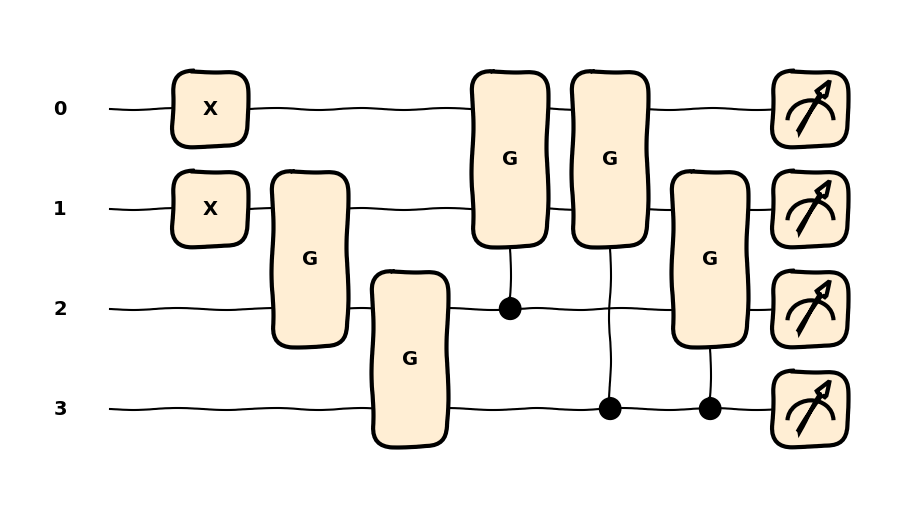

/Users/sym4p/lec_uu_drive/Lecture_SummerSchool2025/myenv/lib/python3.13/site-packages/pennylane/ops/op_math/composite.py:209: FutureWarning: functools.partial will be a method descriptor in future Python versions; wrap it in staticmethod() if you want to preserve the old behavior
  return self._math_op(math.vstack(eigvals), axis=0)


Initial guess
E 7.852599799498703 Egs_exact 1.1898518351360725 Diff. 6.662747964362631
Optimized
E 1.1898518351360716 Egs_exact 1.1898518351360725 Diff. -8.881784197001252e-16


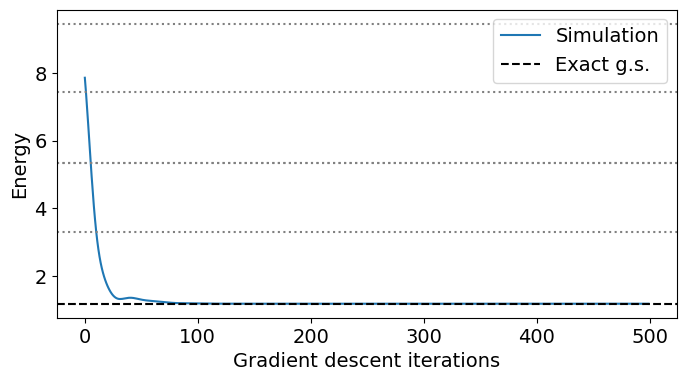

params Opt:   [-0.48104816  1.03977633 -0.9896352  -5.09835587  5.73477388]
params_exact: [-0.48104816 -1.03977633 -0.9896352  -1.18482944 -0.54841143]


In [29]:
def plot_Energy_Opt(energies):
    plt.rcParams["font.size"] = 14
    plt.figure(figsize=(8, 4))
    plt.plot(energies, label="Simulation")
    for eval in evals:
        plt.axhline(y=eval, color="gray", linestyle="dotted")
    plt.axhline(y=Egs_exact, color="black", linestyle="dashed", label="Exact g.s.")
    plt.xlabel("Gradient descent iterations")
    plt.ylabel("Energy")
    plt.legend()
    plt.show()

def call_ansatz(params, ret="H"):   
    for i in range(Nocc):
        qml.PauliX(wires=i)
    qml.SingleExcitation(params[0], wires=[1,2])
    qml.SingleExcitation(params[1], wires=[2,3])
    qml.ctrl(qml.SingleExcitation, control=[2])(params[2], wires=[0,1])
    qml.ctrl(qml.SingleExcitation, control=[3])(params[3], wires=[0,1])
    qml.ctrl(qml.SingleExcitation, control=[3])(params[4], wires=[1,2])
    if ret == "H":
        return qml.expval(H_qubit)
    elif ret == "Z":
        return np.array([ qml.sample(qml.PauliZ(i)) for i in range(Norb)])   
    elif ret == "state":
        return qml.state()

dev = qml.device("default.qubit", wires=Norb) 
@qml.qnode(dev)
def ansatz(params):
    return call_ansatz(params, "H")

# Specifying the initial parameters
num_params = 5
params = np.random.uniform(-np.pi, +np.pi, num_params)

# Drawing the circuit
style="sketch"
qml.drawer.use_style(style)
fig, ax  = qml.draw_mpl(ansatz)(params)
plt.show()
plt.close()

# Calculating the energy
E = ansatz(params)
print("Initial guess\nE", E, "Egs_exact", Egs_exact, "Diff.", E - Egs_exact)

# Optimizing parameters (not working)
if True: #False:
    N_its = 500
    energies = []
    optimizer = qml.AdamOptimizer(stepsize=1.e-1)
    for _ in range(N_its):
        params, _cost = optimizer.step_and_cost(ansatz, params)    
        energies.append(_cost)
    plot_Energy_Opt(energies)
    E = ansatz(params)
    print("Optimized\nE", E, "Egs_exact", Egs_exact, "Diff.", E - Egs_exact)
    print("params Opt:  ", params)
    print("params_exact:", params_exact)

デバイスの設定でshot数を設定すると、statevectorではなく、結果の統計を得ることができる。

In [ ]:
def sample_to_counts(sample):
    n_qubits, n_shots = np.shape(sample)
    sample_bin = (1-np.array(sample))/2
    dict_counts = { }
    for i in range(n_shots):
        label = ''.join([str(int(sample_bin[j,i])) for j in range(n_qubits)])
        dict_counts[label] = dict_counts.get(label, 0) + 1
    return dict_counts

dev = qml.device("default.qubit", wires=range(Norb), shots=10000)
@qml.qnode(dev)
def ansatz(params):
    return call_ansatz(params, "Z")

params = params_exact

config_ordered = [ ] 
for config in itertools.combinations(range(Norb),Nocc):
    config_ordered += [f'{sum([2**i for i in config]):0{Norb}b}']

labels = sorted(config_ordered,reverse=True)
counts = sample_to_counts(ansatz(params))
values = [ ]
for config in labels:
    values.append(counts.get(config, 0))
values = np.array(values) / np.sum(values)

fig = plt.figure(figsize=(10, 4))
plt.bar(labels,values)
for i in range(len(labels)):
    plt.text(i, values[i], str(values[i]), ha='center', va='bottom')
plt.xlabel('bitstrings')
plt.ylabel('counts')
plt.xticks(rotation=90)
plt.show()
plt.close()


In [ ]:
# Checking the state-vector
dev = qml.device("default.qubit", wires=range(Norb))
@qml.qnode(dev)
def ansatz(params):
    return call_ansatz(params, "state")

ansatz(params)

## 補足

pennylaneでは標準のバックエンド`dev = qml.device("default.qubit", wires=n_qubits)`に加えて、
C++による高速なstatevectorのシミュレーションが可能なバックエンドも用意されている。

```python
dev = qml.device("lightning.qubit", wires=n_qubits)
```

などとしてやれば良い。ただし、最近Pythonのライブラリの依存関係の考え方が変わり、
brewやaptなどシステムのパッケージマネージャ経由でインストールすべし、とされている。

このあたりの事情から、少々手こずるかもしれない。
依存関係ぶっ壊れてもいいからpipで強引にインストールする方法もあるが、仮想環境の作成が推奨ということであろう。